In [133]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from src.models import LinearRegression
from src.loss import MSE
from src.optimizers.gd import GD
from src.regularizers import L1, L2, Elastic_Net

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [134]:
X, y = make_regression(
    n_samples=500, n_features=100, n_informative=5, noise=20, random_state=42
)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((400, 100), (400,), (100, 100), (100,))

In [135]:
n_train = X_train.shape[0]
epochs = 500
lr = 0.01


def get_steps(batch_size, n_samples, epochs):
    if batch_size is None:
        return epochs
    else:
        return int((n_samples / batch_size) * epochs)


# Full Batch (GD)
model_none = LinearRegression(
    loss=MSE(),
    opt=GD(lr=lr),
    steps=get_steps(None, n_train, epochs),
    reg=None,
    batch_size=None,
)

# Mini-Batch 20 (SGD)
model_l1 = LinearRegression(
    loss=MSE(),
    opt=GD(lr=lr),
    steps=get_steps(20, n_train, epochs),
    reg=L1(alpha=5.0),
    batch_size=20,
    lmd=0.05,
)

# Mini-Batch 30
model_l2 = LinearRegression(
    loss=MSE(),
    opt=GD(lr=lr),
    steps=get_steps(30, n_train, epochs),
    reg=L2(alpha=0.05),
    batch_size=30,
    lmd=0.1,
)

# Mini-Batch 5
model_en = LinearRegression(
    loss=MSE(),
    opt=GD(lr=lr),
    steps=get_steps(5, n_train, epochs),
    reg=Elastic_Net(alpha=0.05, l1_ratio=0.5),
    batch_size=5,
    lmd=0.1,
)

model_none.fit(X_train, y_train)
model_l1.fit(X_train, y_train)
model_l2.fit(X_train, y_train)
model_en.fit(X_train, y_train)

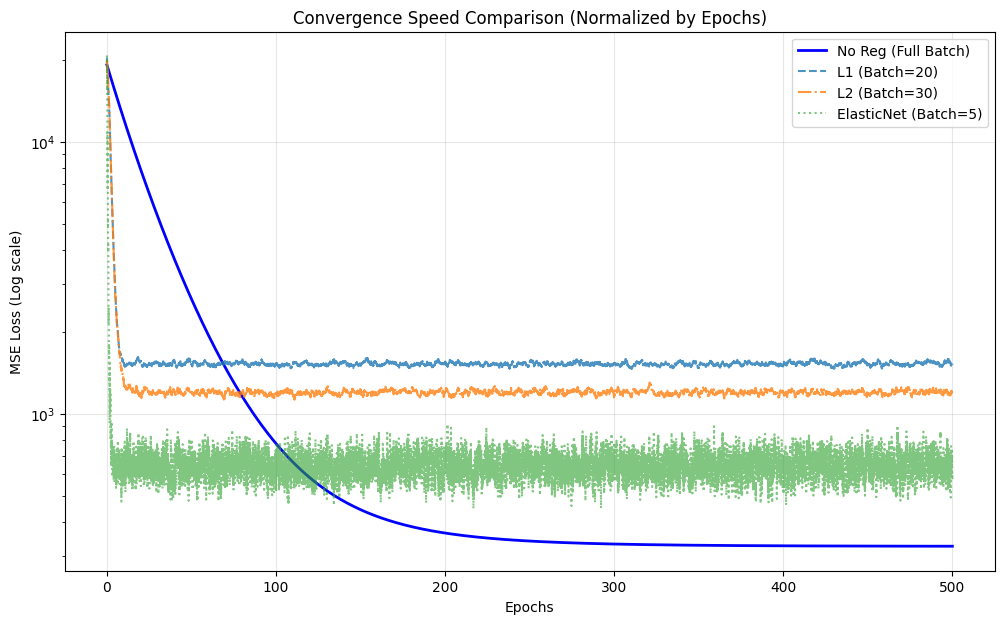

In [136]:
plt.figure(figsize=(12, 7))


def get_x_axis(history, epochs):
    return np.linspace(0, epochs, len(history))


plt.plot(
    get_x_axis(model_none.history, epochs),
    model_none.history,
    label="No Reg (Full Batch)",
    linewidth=2,
    color="blue",
)
plt.plot(
    get_x_axis(model_l1.history, epochs),
    model_l1.history,
    label="L1 (Batch=20)",
    linestyle="--",
    alpha=0.8,
)
plt.plot(
    get_x_axis(model_l2.history, epochs),
    model_l2.history,
    label="L2 (Batch=30)",
    linestyle="-.",
    alpha=0.8,
)
plt.plot(
    get_x_axis(model_en.history, epochs),
    model_en.history,
    label="ElasticNet (Batch=5)",
    linestyle=":",
    alpha=0.6,
)

plt.xlabel("Epochs")
plt.ylabel("MSE Loss (Log scale)")
plt.title("Convergence Speed Comparison (Normalized by Epochs)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale("log")
plt.show()

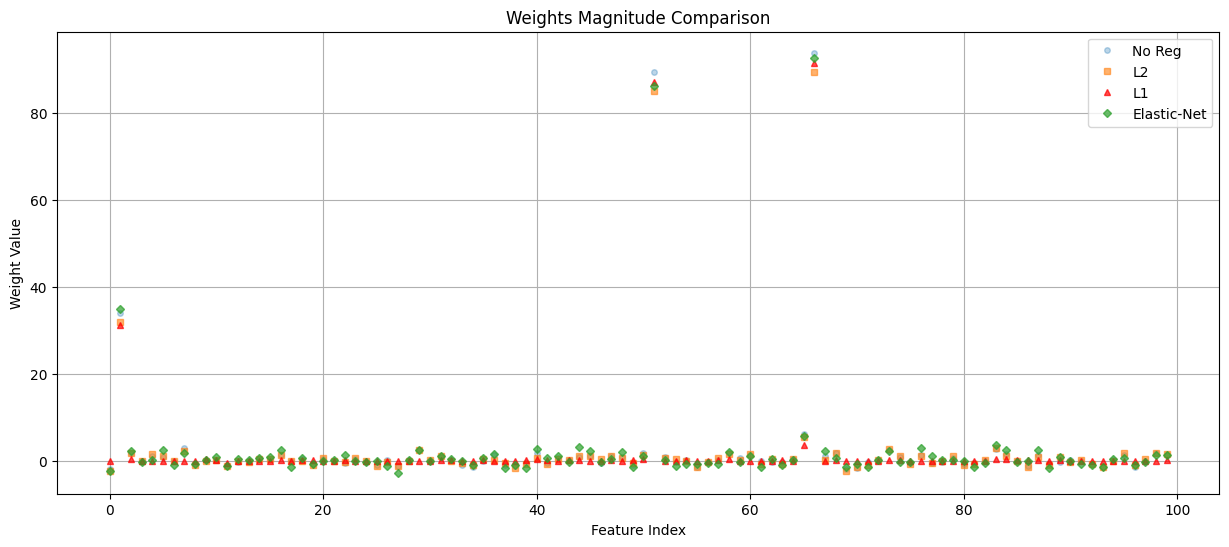

Zero weights in No Reg: 0
Zero weights in L2: 0
Zero weights in L1: 26
Zero weights in Elastic-Net: 0


In [137]:
plt.figure(figsize=(15, 6))

w_none = model_none.w[1:]
w_l1 = model_l1.w[1:]
w_l2 = model_l2.w[1:]
w_en = model_en.w[1:]

plt.plot(w_none, "o", label="No Reg", alpha=0.3, markersize=4)
plt.plot(w_l2, "s", label="L2", alpha=0.6, markersize=4)
plt.plot(w_l1, "^", label="L1", color="red", alpha=0.7, markersize=4)
plt.plot(w_en, "D", label="Elastic-Net", alpha=0.7, markersize=4)

plt.title("Weights Magnitude Comparison")
plt.xlabel("Feature Index")
plt.ylabel("Weight Value")
plt.legend()
plt.grid(True)
plt.show()

print(f"Zero weights in No Reg: {np.sum(np.abs(w_none) < 1e-4)}")
print(f"Zero weights in L2: {np.sum(np.abs(w_l2) < 1e-4)}")
print(f"Zero weights in L1: {np.sum(np.abs(w_l1) < 1e-4)}")
print(f"Zero weights in Elastic-Net: {np.sum(np.abs(w_en) < 1e-4)}")

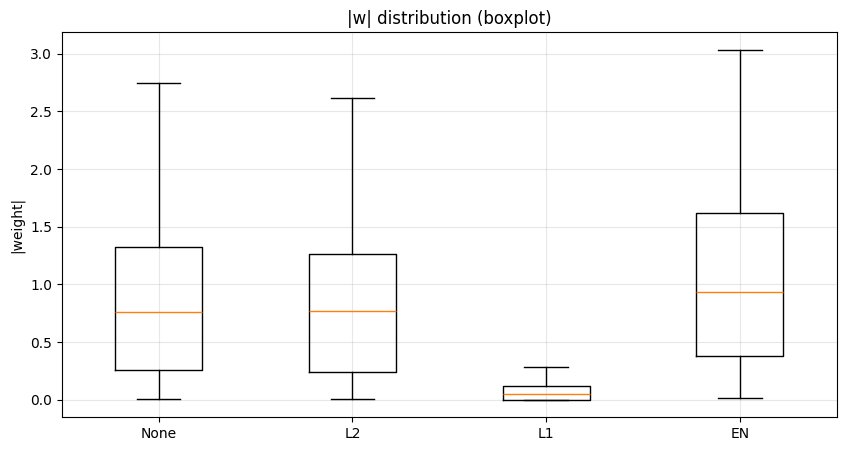

In [138]:
weights = {
    "None": np.abs(model_none.w[1:]),
    "L2": np.abs(model_l2.w[1:]),
    "L1": np.abs(model_l1.w[1:]),
    "EN": np.abs(model_en.w[1:]),
}

plt.figure(figsize=(10, 5))
plt.boxplot(list(weights.values()), tick_labels=list(weights.keys()), showfliers=False)
plt.title("|w| distribution (boxplot)")
plt.ylabel("|weight|")
plt.grid(True, alpha=0.3)
plt.show()

In [139]:
y_pred_none = model_none.predict(X_test)
y_pred_l1 = model_l1.predict(X_test)
y_pred_l2 = model_l2.predict(X_test)
y_pred_en = model_en.predict(X_test)

print(f"None: {MSE()(y_test, y_pred_none)}")
print(f"L1 (Lasso): {MSE()(y_test, y_pred_l1)}")
print(f"L2 (Ridge): {MSE()(y_test, y_pred_l2)}")
print(f"Elastic-Net: {MSE()(y_test, y_pred_en)}")

None: 547.6807494369561
L1 (Lasso): 433.29572310717754
L2 (Ridge): 627.6550906548014
Elastic-Net: 603.7862738079057
